In [30]:
import os
import nd2
import pickle
import napari
import numpy as np
import pandas as pd
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as patches
import colorcet as ccset
import seaborn as sns
from skimage import draw
from skimage.morphology import disk,dilation
from scipy.ndimage import distance_transform_edt

In [2]:
path_dir = r'D:\data_analysis\2022_Sahana\data\Collagen\60x images'
im_name = r'092622_ring_PDMSAp_10MCol_647-Act_561-Pax_488-Plak_DAPI_001.nd2'
path_im = os.path.join(path_dir,im_name)

path_vertices = r'D:\data_analysis\2022_Sahana\masks'

path_results = r'D:\data_analysis\2022_Sahana\results'
path_df = os.path.join(path_results,im_name.replace('.nd2','_df.pkl'))

# order of channels
    # actin
    # paxilin
    # plakoglobin
    # DAPI


## Read in the image, annotations and the data frame

In [3]:
# read in image
im = nd2.imread(path_im)
im.shape

(27, 4, 512, 512)

In [4]:
# read in polygons and masks

pkl_path = os.path.join(path_vertices,im_name.replace('.nd2','_polygons.pkl'))

with open(pkl_path, 'rb') as f:
    vertices_polygons = pickle.load(f)

mask_path = os.path.join(path_vertices,im_name.replace('.nd2','_mask.png'))
mask = imread(mask_path)

In [5]:
df = pd.read_pickle(path_df)

## Visualize orientation of cell edge

In [55]:
cell = df.loc[3,:]
vertices = (cell.vertices - np.array([cell['bbox-0'],cell['bbox-1']])).astype(int)
orientations = (np.array(cell.membrane_orientation) + np.pi/2)/np.pi
color = ccset.cm.colorwheel(orientations)

In [56]:
cell

label                                                                   4
area                                                                17279
centroid-0                                                     221.896348
centroid-1                                                     231.103131
bbox-0                                                                141
bbox-1                                                                144
bbox-2                                                                291
bbox-3                                                                332
eccentricity                                                     0.792619
orientation                                                      1.247677
intensity_image         [[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, ...
image                   [[False, False, False, False, False, False, Fa...
image_name              092622_ring_PDMSAp_10MCol_647-Act_561-Pax_488-...
vertices                [[290.5, 186.0

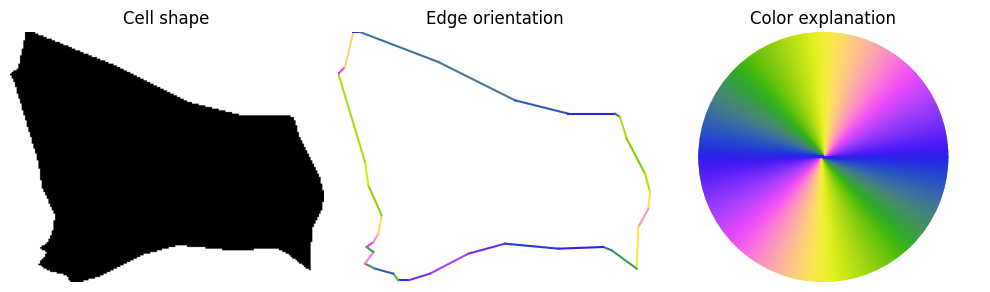

In [57]:
fig,axes = plt.subplots(1,3,figsize=(10,6))

axes[0].imshow(cell.image,cmap=cm.gray_r)
axes[0].set_title('Cell shape')

############################################################################################
axes[1].imshow(np.ones(cell.image.shape),cmap=cm.gray_r)
axes[1].set_title('Edge orientation')

for i in range(len(vertices)):
    
    p0 = vertices[i]

    if (i == (len(vertices)-1)):
        p1 = vertices[0]
    else:
        p1 = vertices[i+1]
    
    axes[1].plot((p0[1], p1[1]), (p0[0], p1[0]),c = color[i])


axes[1].set_xlim((0, cell.image.shape[1]))
axes[1].set_ylim((cell.image.shape[0], 0))

############################################################################################
axes[2].imshow(np.ones(cell.image.shape),cmap=cm.gray_r)
axes[2].set_title('Color explanation')

im_center = (int(cell.image.shape[1]/2), (int(cell.image.shape[0]/2)))
patch = patches.Circle(im_center, radius=int(np.min(cell.image.shape)/2), transform=axes[2].transData)

for angle in np.linspace(0,np.pi,360):

    slope = -np.tan(angle)

    t = axes[2].axline(im_center, slope=slope,c=ccset.cm.colorwheel(angle/(np.pi)))
    t.set_clip_path(patch)


axes[2].set_xlim((0, cell.image.shape[1]))
axes[2].set_ylim((cell.image.shape[0], 0))

############################################################################################
for a in axes:
    a.set_axis_off()

plt.tight_layout()
plt.show()


## Visualize actin orientation

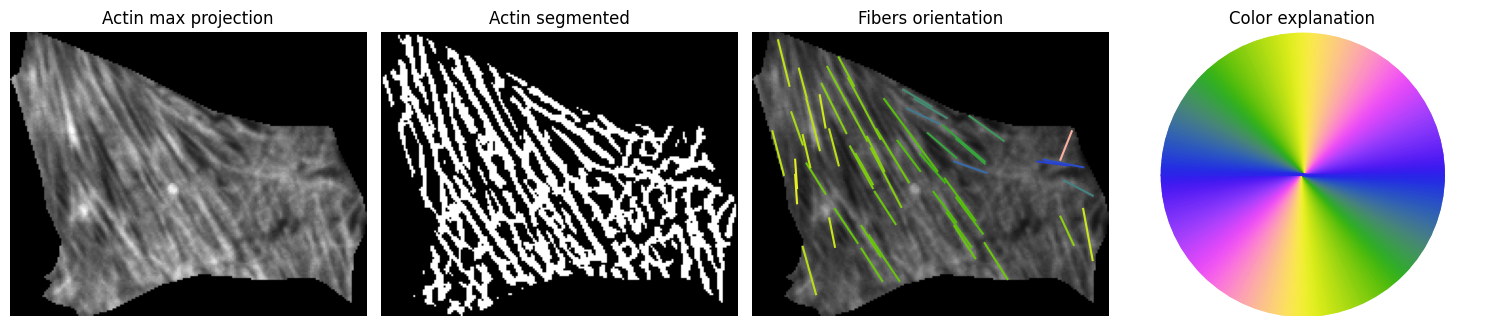

In [58]:
fig,axes = plt.subplots(1,4,figsize=(15,6))

############################################################################################
actin_image = cell.intensity_image[:,:,0]
axes[0].imshow(actin_image,cmap=cm.gray)
axes[0].set_title('Actin max projection')
############################################################################################
axes[1].imshow(cell.intensity_image[:,:,4],cmap=cm.gray)
axes[1].set_title('Actin segmented')

############################################################################################
axes[2].imshow(actin_image,cmap=cm.gray,vmax=np.max(actin_image)*1.5)
axes[2].set_title('Fibers orientation')

for line,angle in zip(cell.actin_detected,cell.actin_angles):

    p0,p1 = line
    axes[2].plot((p0[0], p1[0]), (p0[1], p1[1]),c = ccset.cm.colorwheel((angle+np.pi/2)/(np.pi)))

############################################################################################

axes[3].imshow(np.ones(cell.image.shape),cmap=cm.gray_r)
axes[3].set_title('Color explanation')

im_center = (int(cell.image.shape[1]/2), (int(cell.image.shape[0]/2)))
patch = patches.Circle(im_center, radius=int(np.min(cell.image.shape)/2), transform=axes[3].transData)

for angle in np.linspace(0,np.pi,360):

    slope = -np.tan(angle)

    t = axes[3].axline(im_center, slope=slope,c=ccset.cm.colorwheel(angle/(np.pi)))
    t.set_clip_path(patch)


############################################################################################
for a in axes:
    a.set_axis_off()

plt.tight_layout()
plt.show()

## Edge orientation vs main flow of actin

In [59]:
def calculate_perpendicular_index(angle_actin,angle_membrane):
    
    orientation = np.abs(np.abs(np.abs(angle_membrane - angle_actin) - (np.pi/2))/(np.pi/2)-1)

    return orientation

orientations = []
for angle_membrane in cell.membrane_orientation:

    orientation = calculate_perpendicular_index(cell.actin_orientation,angle_membrane)

    orientations.append(orientation)


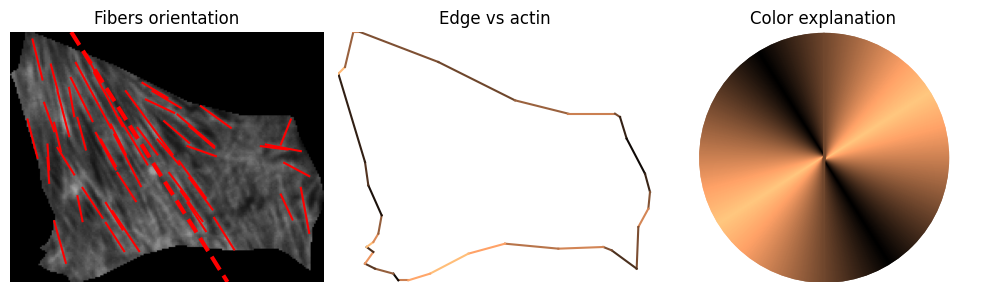

In [60]:
fig,axes = plt.subplots(1,3,figsize=(10,6))

color = cm.copper(orientations)

############################################################################################
actin_image = cell.intensity_image[:,:,0]
axes[0].imshow(actin_image,cmap=cm.gray,vmax=np.max(actin_image)*1.5)
axes[0].set_title('Fibers orientation')

for line,angle in zip(cell.actin_detected,cell.actin_angles):

    p0,p1 = line
    axes[0].plot((p0[0], p1[0]), (p0[1], p1[1]),c = 'red')


cell_center = [cell['centroid-1']-cell['bbox-1'],cell['centroid-0']-cell['bbox-0']]

axes[0].axline(cell_center, slope=-np.tan(cell.actin_orientation+np.pi/2),c='red',linewidth=3,linestyle='--')
############################################################################################
axes[1].imshow(np.ones(cell.image.shape),cmap=cm.gray_r)
axes[1].set_title('Edge vs actin')

for i in range(len(vertices)):
    
    p0 = vertices[i]

    if (i == (len(vertices)-1)):
        p1 = vertices[0]
    else:
        p1 = vertices[i+1]
    
    axes[1].plot((p0[1], p1[1]), (p0[0], p1[0]),c = color[i])



axes[1].set_xlim((0, cell.image.shape[1]))
axes[1].set_ylim((cell.image.shape[0], 0))

############################################################################################

axes[2].imshow(np.ones(cell.image.shape),cmap=cm.gray_r)
axes[2].set_title('Color explanation')

patch = patches.Circle(im_center, radius=int(np.min(cell.image.shape)/2), transform=axes[2].transData)

for angle in np.linspace(0,np.pi,360):

    slope = -np.tan(angle-np.pi/2)
    orientation = calculate_perpendicular_index(cell.actin_orientation,angle)

    t = axes[2].axline(im_center, slope=slope,c=cm.copper(orientation))
    t.set_clip_path(patch)


############################################################################################
for a in axes:
    a.set_axis_off()

plt.tight_layout()
plt.show()

## Calculate edge orientation based on edge regions

In [61]:
# prepare image of edge orientation vs actin
edge_image = np.ones(cell.image.shape)*0

for i,o in zip(range(len(vertices)),orientations):
    
    p0 = vertices[i]

    if (i == (len(vertices)-1)):
        p1 = vertices[0]
    else:
        p1 = vertices[i+1]

    rr,cc = draw.line(p0[0],p0[1],p1[0],p1[1])
    edge_image[rr,cc] = o

edge_image = dilation(edge_image,disk(1))

# measure orientation in the x axis of regions
points_array = cell['outside_ring_regions']

signal_list = []

for x in range(25):

    points_selected = points_array[points_array[:,2]==x,:]

    signals = np.array([edge_image[x[0],x[1]] for x in np.array([points_selected[:,0],points_selected[:,1]]).T])

    signal = np.mean(signals[signals>0])

    signal_list.append(signal)

edge_vs_actin_array = np.array(signal_list)

Text(0, 0.5, 'parallel -> perpendicular')

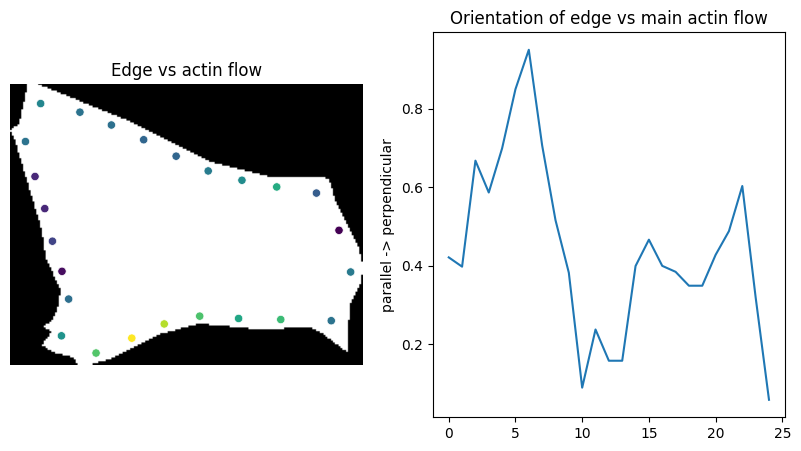

In [62]:
points_df = pd.DataFrame(cell.outside_ring_regions,columns=['x','y','set'])
points_centroid = pd.DataFrame(points_df.groupby('set').mean())
points_centroid['signal'] = signal_list

cmap = cm.get_cmap('viridis', len(set(points_array[:,2]))) 

fig,axes = plt.subplots(1,2,figsize=(10,5))

axes[0].imshow(cell.image,cmap=cm.gray)
sns.scatterplot(data=points_centroid,x='y',y='x',hue='signal',palette='viridis',ax=axes[0],legend=False)
axes[0].set_title('Edge vs actin flow')
axes[0].set_axis_off()

axes[1].plot(edge_vs_actin_array)
axes[1].set_title('Orientation of edge vs main actin flow')
axes[1].set_ylabel('parallel -> perpendicular')

## Characterize distribution of plakoglobin

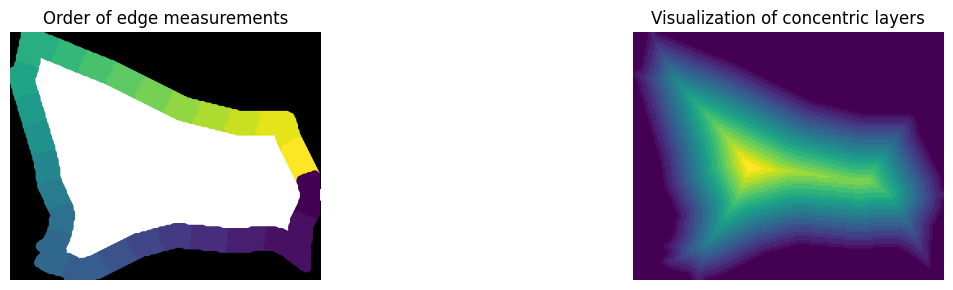

In [63]:
fig,axes = plt.subplots(1,2,figsize=(15,3))

axes[0].imshow(cell.image,cmap=cm.gray)
axes[0].scatter(points_df.y,points_df.x,c=cmap(points_df.set))
axes[0].set_title('Order of edge measurements')

layer_num = 20

# generate distance transform
cell_shape = cell.image
dist = distance_transform_edt(cell_shape)

# digitize distance transform
step = np.max(dist)/layer_num

for n in range(layer_num):

    dist[(dist>(n*step)) & (dist<=((n+1)*step))] = n+1

axes[1].imshow(dist)
axes[1].set_title('Visualization of concentric layers')


for a in axes:
    a.set_axis_off()

plt.tight_layout()
plt.show()

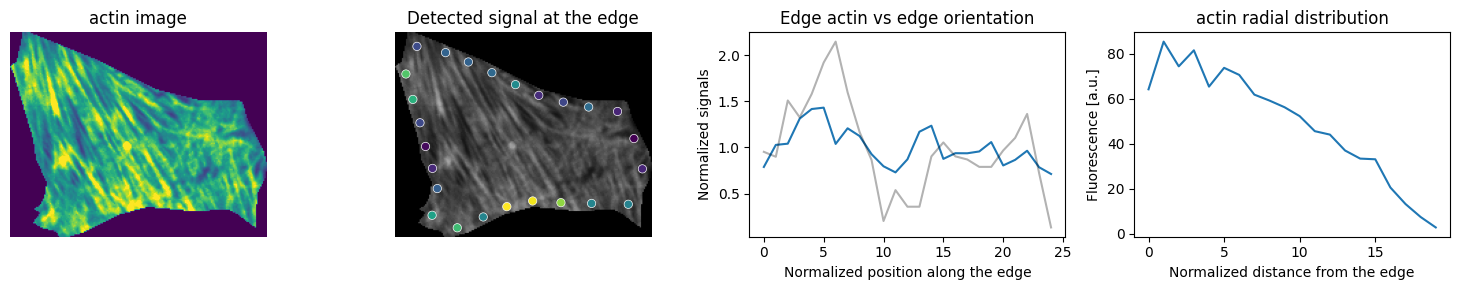

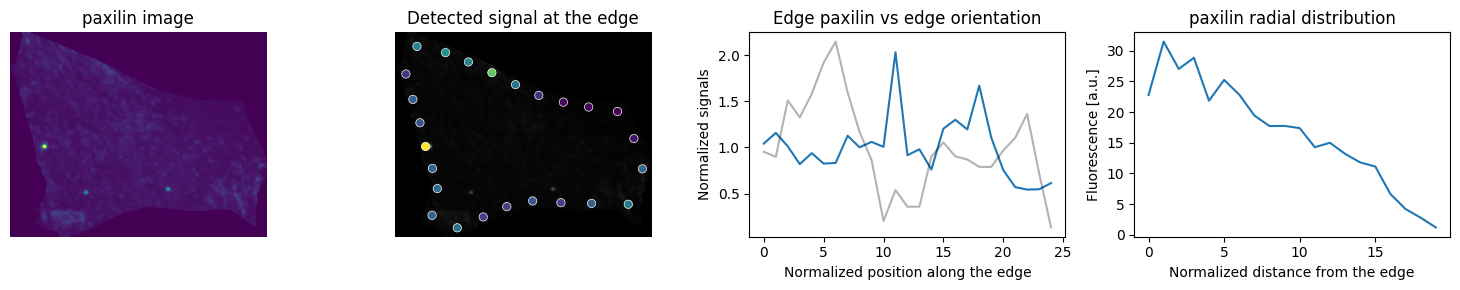

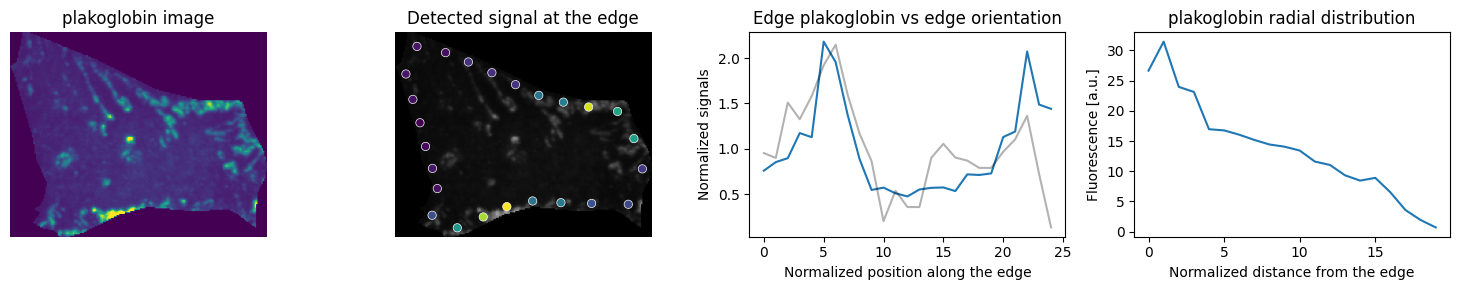

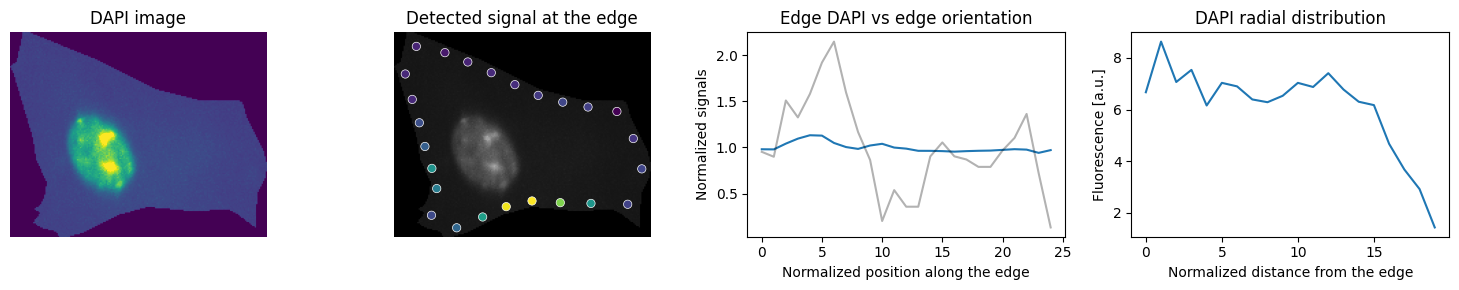

In [64]:
for s,s_name in zip(range(4),['actin','paxilin','plakoglobin','DAPI']):

    im = cell.intensity_image[:,:,s]
    points_df = pd.DataFrame(cell.outside_ring_regions,columns=['x','y','set'])
    points_centroid = pd.DataFrame(points_df.groupby('set').mean())
    points_centroid['signal'] = cell[f'signal_edge_{str(s).zfill(2)}']

    cmap = cm.get_cmap('viridis', len(set(points_array[:,2]))) 

    fig,axes = plt.subplots(1,4,figsize=(15,3))

    axes[0].imshow(im,cmap=cm.viridis,vmax=np.max(im)*0.7)
    axes[0].set_title(f'{s_name} image')

    axes[1].imshow(im,cmap=cm.gray,vmax=np.max(im)*1.5)
    sns.scatterplot(data=points_centroid,x='y',y='x',hue='signal',palette='viridis',ax=axes[1],legend=False)
    axes[1].set_title('Detected signal at the edge')

    axes[2].plot(points_centroid['signal']/np.mean(points_centroid['signal']))
    axes[2].plot(edge_vs_actin_array/np.mean(edge_vs_actin_array),alpha=0.3,color='black')
    axes[2].set_title(f'Edge {s_name} vs edge orientation')
    axes[2].set_xlabel('Normalized position along the edge')
    axes[2].set_ylabel('Normalized signals')

    axes[3].plot(cell[f'signal_radial_{str(s).zfill(2)}'])
    axes[3].set_title(f'{s_name} radial distribution')
    axes[3].set_xlabel('Normalized distance from the edge')
    axes[3].set_ylabel('Fluorescence [a.u.]')

    ############################################################################################
    for a in axes[:2]:
        a.set_axis_off()

    plt.tight_layout()
    plt.show()